# British Airways Seat Reviews

# Import required libraries

In [55]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import logging
from requests.exceptions import RequestException

# Set up logging (helpful for debugging)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


# Web Scrape

### Define target URL 

In [56]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"

In [57]:
all_reviews = [] # Changed variable name from reviews to all_reviews to avoid same name

# Handle Pagination
pages = 37 # Define the number of pages *before* using it
# Adjust based on the actual number of pages
page_size = 100

# 2. Implement Robust Error Handling
def scrape_page(page_num, base_url, page_size):
    """Scrapes a single page of reviews and handles potential errors."""
    url = f"{base_url}/page/{page_num}/?sort=post_date%3ADesc&pagesize={page_size}"
    logging.info(f"Scraping page {page_num}: {url}")  # Log the URL

    try:
        response = requests.get(url, timeout=10)  # Add a timeout
        response.raise_for_status()  # Raise HTTPError for bad responses (4xx or 5xx)

        soup = BeautifulSoup(response.content, 'html.parser')
        page_reviews = soup.find_all("div", class_="text_content")

        reviews = [review.get_text(strip=True) for review in page_reviews]
        logging.info(f"Page {page_num}: Extracted {len(reviews)} reviews.")
        return reviews

    except RequestException as e:
        logging.error(f"Page {page_num}: Request failed - {e}")
        return []  # Return an empty list in case of an error
    except Exception as e:
        logging.error(f"Page {page_num}: An unexpected error occurred - {e}")
        return []

# Modified Scraping Loop: Using the new function to scrape each page
for page in range(1, pages + 1):
    page_reviews = scrape_page(page, base_url, page_size)
    all_reviews.extend(page_reviews) # Append new reviews to total reviews

    logging.info(f"Total reviews scraped so far: {len(all_reviews)}")
    time.sleep(2)  # Respect the server


2025-03-26 16:39:39,469 - INFO - Scraping page 1: https://www.airlinequality.com/airline-reviews/british-airways/page/1/?sort=post_date%3ADesc&pagesize=100
2025-03-26 16:39:41,750 - INFO - Page 1: Extracted 100 reviews.
2025-03-26 16:39:41,751 - INFO - Total reviews scraped so far: 100
2025-03-26 16:39:43,752 - INFO - Scraping page 2: https://www.airlinequality.com/airline-reviews/british-airways/page/2/?sort=post_date%3ADesc&pagesize=100
2025-03-26 16:39:45,646 - INFO - Page 2: Extracted 100 reviews.
2025-03-26 16:39:45,647 - INFO - Total reviews scraped so far: 200
2025-03-26 16:39:47,652 - INFO - Scraping page 3: https://www.airlinequality.com/airline-reviews/british-airways/page/3/?sort=post_date%3ADesc&pagesize=100
2025-03-26 16:39:49,716 - INFO - Page 3: Extracted 100 reviews.
2025-03-26 16:39:49,717 - INFO - Total reviews scraped so far: 300
2025-03-26 16:39:51,722 - INFO - Scraping page 4: https://www.airlinequality.com/airline-reviews/british-airways/page/4/?sort=post_date%3AD

In [58]:
# 3. Ensure Data Quality and Representativeness (Initial Checks)
df = pd.DataFrame(all_reviews, columns=['Review'])

# Basic Stats & Checks
logging.info(f"Total reviews scraped: {len(df)}")

# Check for empty reviews
empty_reviews = df[df['Review'].str.len() == 0]
logging.warning(f"Number of empty reviews: {len(empty_reviews)}")

# Remove empty reviews (if any)
df = df[df['Review'].str.len() > 0]

# Check for duplicates *before* cleaning
duplicates_before = df.duplicated().sum()
logging.warning(f"Number of duplicate reviews before cleaning: {duplicates_before}")

# Clean the review column, remove duplicates, handle missing values and shorter reviews
df['Review'] = df['Review'].str.replace(r"￿Trip Verified\|", "", regex=True)
df['Review'] = df['Review'].str.strip()
df = df.dropna(subset=['Review'])
df = df.drop_duplicates(subset=['Review'], keep='first')
df = df[df['Review'].str.len() > 10]

# Save the dataframe to csv file
df.to_csv('/users/isaganijulian/downloads/skytrax_reviews.csv', index=False)
logging.info(f"Total reviews saved to CSV: {len(df)}")


2025-03-26 16:42:04,667 - INFO - Total reviews scraped: 3700
2025-03-26 16:42:04,674 - WARNING - Number of empty reviews: 0
2025-03-26 16:42:04,681 - WARNING - Number of duplicate reviews before cleaning: 9
2025-03-26 16:42:04,728 - INFO - Total reviews saved to CSV: 3691


# Clean the df

In [59]:
# Check the first couple of rows
print(df.head())


                                              Review
0  ✅Trip Verified|   Flight mainly let down by a ...
1  ✅Trip Verified|   Another awful experience by ...
2  ✅Trip Verified|   The service was rude, full o...
3  ✅Trip Verified|   This flight was a joke. Ther...
4  ✅Trip Verified|   This time British Airways ma...


In [60]:
# Clean the review column 
df['Review'] = df['Review'].str.replace(r"✅Trip Verified\|", "", regex=True)

# Strip leading
df['Review'] = df['Review'].str.strip()

# Handle missing values
df = df.dropna(subset=['Review'])

# Remove duplicates
df = df.drop_duplicates(subset=['Review'], keep='first')

# Handle shorter reviews
df = df[df['Review'].str.len() > 10]

# Saved cleaned data
df.to_csv('/users/isaganijulian/downloads/cleaned_skytrax_reviews.csv', index=False)
print("Cleaned data saved to 'cleaned_skytrax_reviews.csv'")

Cleaned data saved to 'cleaned_skytrax_reviews.csv'


In [61]:
df.head()

,Review
0,Flight mainly let down by a disagreeable fligh...
1,Another awful experience by British Airways. T...
2,"The service was rude, full of attitude to me, ..."
3,This flight was a joke. There was four people ...
4,This time British Airways managed to get every...


### Tokenization and Stopwords removal

In [62]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import contractions

# Load  data
df = pd.read_csv('cleaned_skytrax_reviews.csv')

# 1. Define Preprocessing Functions
def expand_contractions(text):
    return contractions.fix(text)

def remove_punctuation(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

# 2. Create Stopword List (and lowercase it!)
stop_words = set(word.lower() for word in stopwords.words('english'))
additional_stopwords = {'flight', 'flights', 'ba', 'british', 'airways', 'would', 'could', 'airline', 'plane', 'seat', 'one', 'get', 'use'}
stop_words.update(additional_stopwords)

def remove_stopwords(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# 3. Apply Preprocessing (in the correct order)
df['cleaned_review'] = df['Review'].astype(str).apply(expand_contractions) # Expand contaction
df['cleaned_review'] = df['cleaned_review'].apply(remove_punctuation) # Remove punctuation
df['cleaned_review'] = df['cleaned_review'].str.lower() #Lowercase!
df['cleaned_review'] = df['cleaned_review'].apply(remove_stopwords) # Remove stopwords

# Display the cleaned reviews
print(df['cleaned_review'].head())


0    mainly let disagreeable attendant queue check ...
1    another awful experience delayed nearly 1 hour...
2    service rude full attitude food poorly service...
3    joke four people business class including comp...
4    time managed everything right price tickets re...
Name: cleaned_review, dtype: object


### Lemmatization and Topic Modeling

In [63]:
import pandas as pd
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import CoherenceModel
import re
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# 1. Load data
df = pd.read_csv('cleaned_skytrax_reviews.csv')

# 2. Define POS tag mapping (more comprehensive)
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun if unknown

# 3. Combined Preprocessing Function (POS tagging, lemmatization, stopword removal)
stop_words = set(stopwords.words('english'))
additional_stopwords = {'flight', 'flights', 'ba', 'british', 'airways', 'would', 'could', 'one', 'get', 'use', 
'go', 'even', 'also', 'however', 'the', 'it', 'I', 'we', 'us', 'time', 'service', 'good', 'fly', 'hour', 'london', 
'staff', 'airline', 'food', 'cabin', 'crew'}
stop_words.update(additional_stopwords)

def preprocess_text(text):
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    # Tokenize
    tokens = word_tokenize(text.lower())
    # Remove stopwords and perform POS tagging + lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(token, pos=get_wordnet_pos(tag))
                         for token, tag in pos_tag(tokens)
                         if token not in stop_words] # Stopwords after tokenization
    return " ".join(lemmatized_words)

# 4. Apply preprocessing
df['processed_review'] = df['Review'].astype(str).apply(preprocess_text)

# 5. Prepare data for topic modeling
documents = df['processed_review'].tolist()
print(f"Number of documents before empty doc removal: {len(documents)}")
documents = [doc for doc in documents if doc]  # Remove empty documents
print(f"Number of documents after empty doc removal: {len(documents)}")

# Add a check
print("\nExample documents after preprocessing:")
for i in range(min(5, len(documents))):  # Print the first 5 or fewer documents
    print(f"Document {i+1}: {documents[i]}")

tokenized_docs = [doc.split() for doc in documents]
dictionary = corpora.Dictionary(tokenized_docs)

print(f"Number of terms in dictionary before filtering: {len(dictionary)}")

dictionary.filter_extremes(no_below=2, no_above=0.4) # Adjust these!

print(f"Number of terms in dictionary after filtering: {len(dictionary)}")

# Print some terms from the dictionary
print("\nExample terms from dictionary:")
for i in range(min(10, len(dictionary))):
    print(f"Term {i+1}: {dictionary[i]}")

corpus = [dictionary.doc2bow(text) for text in tokenized_docs]

# Print the length of the corpus
print(f"\nLength of corpus: {len(corpus)}")
# Also, inspect a few elements of the corpus
print("\nExample elements from corpus:")
for i in range(min(5, len(corpus))):
    print(f"Corpus element {i+1}: {corpus[i]}")

# 6. Train LDA model
num_topics = 10
lda_model = LdaModel(corpus=corpus,
                       id2word=dictionary.id2token,
                       num_topics=num_topics,
                       chunksize=2000,
                       passes=20,
                       iterations=400,
                       eval_every=10) # Evaluate every 10 chunks

# 7. Evaluate topic coherence
coherence_model_lda = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

# 8. Print topics
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

# 9. Visualization
# Prepare the visualization
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)

# Create the HTML visualization
pyLDAvis.save_html(vis_data, 'lda_visualization.html')

print("LDA visualization saved to lda_visualization.html")

2025-03-26 16:42:15,498 - INFO - adding document #0 to Dictionary<0 unique tokens: []>
2025-03-26 16:42:15,606 - INFO - built Dictionary<11606 unique tokens: ['agent', 'alone', 'amenity', 'annoy', 'anyway']...> from 3691 documents (total 265340 corpus positions)
2025-03-26 16:42:15,606 - INFO - Dictionary lifecycle event {'msg': "built Dictionary<11606 unique tokens: ['agent', 'alone', 'amenity', 'annoy', 'anyway']...> from 3691 documents (total 265340 corpus positions)", 'datetime': '2025-03-26T16:42:15.606571', 'gensim': '4.3.0', 'python': '3.11.5 (main, Sep 11 2023, 08:31:25) [Clang 14.0.6 ]', 'platform': 'macOS-14.6.1-arm64-arm-64bit', 'event': 'created'}
2025-03-26 16:42:15,610 - INFO - discarding 5160 tokens: [('disagreeable', 1), ('distaste', 1), ('nuts', 1), ('seat', 2066), ('flirt', 1), ('dozing', 1), ('reline', 1), ('swop', 1), ('unwind', 1), ('somethings', 1)]...
2025-03-26 16:42:15,610 - INFO - keeping 6446 tokens which were in no less than 2 and no more than 1476 (=40.0%) 

Number of documents before empty doc removal: 3691
Number of documents after empty doc removal: 3691

Example documents after preprocessing:
Document 1: mainly let disagreeable attendant queue check cape town checkin agent unfamiliar size weight rule sport bag wait minute phone call make annoy lounge gate excellent organised queue seat new upgraded club suite zip break amenity kit unusable cut corner much offer cocktail come promptly drink excellent nut go galley ask nut snack speak male attendant look utter distaste temerity ask nuts say come bizarre question say seat e respond flick hand ask shes serve stun treat way cheap restaurant let alone business class premium gentleman concern place hospitality find different line work anyway ife work fine wifi wasnt work manage hour sleep get plane promptly despite remote stand require bus luggage take quite arrive overall rude member
Document 2: another awful experience delay nearly charge extortionate amount ticket bad
Document 3: rude full

2025-03-26 16:42:15,689 - INFO - using symmetric alpha at 0.1
2025-03-26 16:42:15,689 - INFO - using symmetric eta at 0.1
2025-03-26 16:42:15,690 - INFO - using serial LDA version on this node
2025-03-26 16:42:15,696 - INFO - running online (multi-pass) LDA training, 10 topics, 20 passes over the supplied corpus of 3691 documents, updating model once every 2000 documents, evaluating perplexity every 3691 documents, iterating 400x with a convergence threshold of 0.001000
2025-03-26 16:42:15,696 - INFO - PROGRESS: pass 0, at document #2000/3691



Length of corpus: 3691

Example elements from corpus:
Corpus element 1: [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 3), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 2), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 2), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 2), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 2), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 2), (65, 1), (66, 2), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 2), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 3), (99, 1)]
Corpus element 2: [(100, 1), (101, 1

2025-03-26 16:42:17,270 - INFO - merging changes from 2000 documents into a model of 3691 documents
2025-03-26 16:42:17,274 - INFO - topic #5 (0.100): 0.007*"hour" + 0.007*"call" + 0.007*"tell" + 0.006*"heathrow" + 0.006*"class" + 0.006*"book" + 0.006*"customer" + 0.006*"pay" + 0.006*"business" + 0.006*"take"
2025-03-26 16:42:17,274 - INFO - topic #3 (0.100): 0.013*"class" + 0.012*"business" + 0.006*"passenger" + 0.006*"heathrow" + 0.006*"fly" + 0.006*"take" + 0.006*"first" + 0.005*"board" + 0.005*"plane" + 0.005*"experience"
2025-03-26 16:42:17,274 - INFO - topic #8 (0.100): 0.008*"take" + 0.007*"make" + 0.007*"economy" + 0.007*"hour" + 0.006*"customer" + 0.006*"delay" + 0.006*"board" + 0.005*"give" + 0.005*"passenger" + 0.005*"verify"
2025-03-26 16:42:17,275 - INFO - topic #7 (0.100): 0.007*"say" + 0.006*"verify" + 0.006*"luggage" + 0.006*"make" + 0.006*"heathrow" + 0.006*"review" + 0.006*"class" + 0.005*"back" + 0.005*"return" + 0.005*"day"
2025-03-26 16:42:17,275 - INFO - topic #4 


Coherence Score:  -3.8850567133966094
Topic: 0 
Words: 0.021*"board" + 0.020*"check" + 0.020*"lounge" + 0.016*"minute" + 0.014*"delay" + 0.014*"passenger" + 0.013*"gate" + 0.013*"boarding" + 0.011*"late" + 0.010*"security"
Topic: 1 
Words: 0.019*"dhabi" + 0.018*"abu" + 0.017*"cancun" + 0.009*"hamburg" + 0.008*"abuja" + 0.008*"basic" + 0.006*"salt" + 0.006*"leaving" + 0.006*"voucher" + 0.006*"instance"
Topic: 2 
Words: 0.032*"heathrow" + 0.026*"manchester" + 0.016*"lhr" + 0.016*"via" + 0.014*"airport" + 0.013*"geneva" + 0.013*"connect" + 0.013*"lax" + 0.012*"miami" + 0.012*"delay"
Topic: 3 
Words: 0.023*"class" + 0.018*"business" + 0.009*"first" + 0.009*"fly" + 0.009*"economy" + 0.007*"passenger" + 0.006*"club" + 0.006*"old" + 0.006*"airline" + 0.005*"plane"
Topic: 4 
Words: 0.011*"make" + 0.011*"travel" + 0.008*"look" + 0.007*"gatwick" + 0.007*"first" + 0.007*"st" + 0.006*"year" + 0.006*"offer" + 0.006*"class" + 0.006*"return"
Topic: 5 
Words: 0.014*"tell" + 0.013*"customer" + 0.011*"

# EDA

count    3692.000000
mean      901.708559
std       587.687602
min        83.000000
25%       485.000000
50%       752.000000
75%      1144.500000
max      3535.000000
Name: review_length, dtype: float64


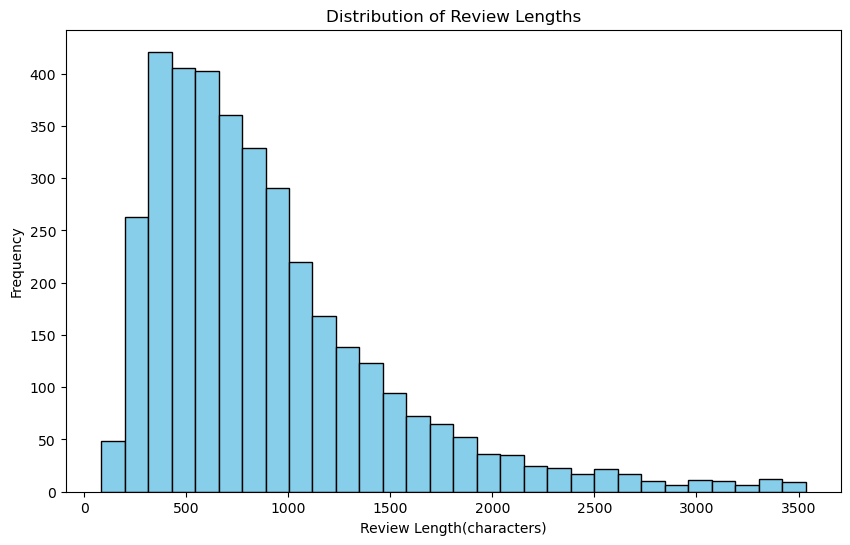

In [37]:
import matplotlib.pyplot as plt
import pandas as pd
# Calculate the length of each review iin character
df['review_length'] = df['Review'].str.len()

print(df['review_length'].describe())

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(df['review_length'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length(characters)')
plt.ylabel('Frequency')
plt.show()

count    3692.000000
mean      163.413597
std       108.574777
min        15.000000
25%        86.000000
50%       135.000000
75%       206.000000
max       655.000000
Name: word_count, dtype: float64


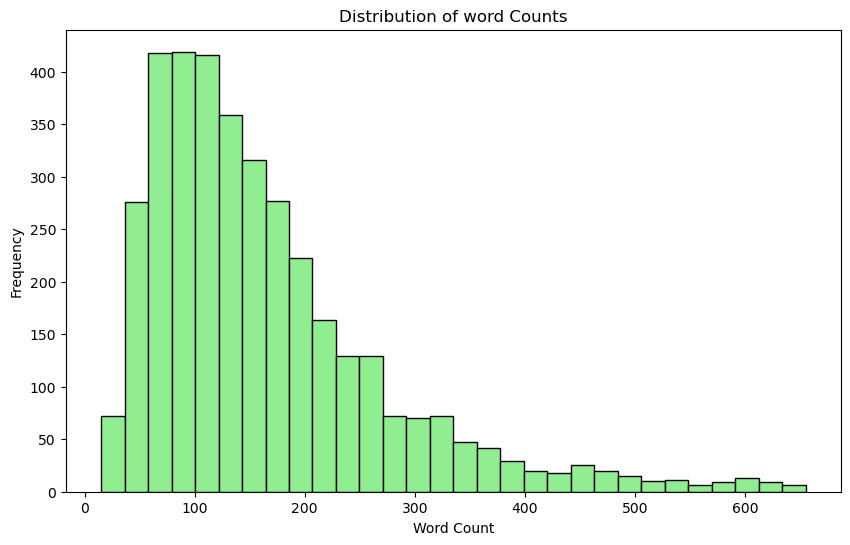

In [40]:
# Check the distribution of words and count the number of words
df['word_count'] = df['Review'].str.split().apply(len)

# Basic Statistics for the word counts
print(df['word_count'].describe())

# Plot a histogram to visualize the distribution of word counts
plt.figure(figsize=(10, 6))
plt.hist(df['word_count'], bins=30, color='lightgreen', edgecolor='black')
plt.title('Distribution of word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

# Sentiment Analysis

In [64]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import nltk

nltk.download('vader_lexicon')
analyzer = SentimentIntensityAnalyzer()

# Load your cleaned data
df2 = pd.read_csv('cleaned_skytrax_reviews.csv')

# Get sentiment scores for all reviews
df2['sentiment_scores'] = df2['Review'].apply(analyzer.polarity_scores)

# Extract compound scores CORRECTLY (fix column name)
df2['compound_sentiment'] = df2['sentiment_scores'].apply(lambda x: x['compound'])  # Singular "sentiment"

# Now categorize using the correct column name
df2['sentiment_category'] = df2['compound_sentiment'].apply(
    lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral')
)

# Verify results
print(df2[['Review', 'compound_sentiment', 'sentiment_category']].head())


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/isaganijulian/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


                                              Review  compound_sentiment  \
0  Flight mainly let down by a disagreeable fligh...             -0.8845   
1  Another awful experience by British Airways. T...             -0.8294   
2  The service was rude, full of attitude to me, ...             -0.4588   
3  This flight was a joke. There was four people ...              0.0000   
4  This time British Airways managed to get every...              0.9831   

  sentiment_category  
0           Negative  
1           Negative  
2           Negative  
3            Neutral  
4           Positive  


In [65]:
df2.head()

,Review,sentiment_scores,compound_sentiment,sentiment_category
0,Flight mainly let down by a disagreeable fligh...,"{'neg': 0.123, 'neu': 0.802, 'pos': 0.075, 'co...",-0.8845,Negative
1,Another awful experience by British Airways. T...,"{'neg': 0.289, 'neu': 0.711, 'pos': 0.0, 'comp...",-0.8294,Negative
2,"The service was rude, full of attitude to me, ...","{'neg': 0.107, 'neu': 0.893, 'pos': 0.0, 'comp...",-0.4588,Negative
3,This flight was a joke. There was four people ...,"{'neg': 0.061, 'neu': 0.857, 'pos': 0.082, 'co...",0.0000,Neutral
4,This time British Airways managed to get every...,"{'neg': 0.0, 'neu': 0.767, 'pos': 0.233, 'comp...",0.9831,Positive


In [66]:
df2.describe()

,compound_sentiment
count,3691.000000
mean,0.144988
std,0.781057
min,-0.997400
25%,-0.741650
50%,0.432500
75%,0.925900
max,0.999200


sentiment_category
Positive    2104
Negative    1576
Neutral       11
Name: count, dtype: int64


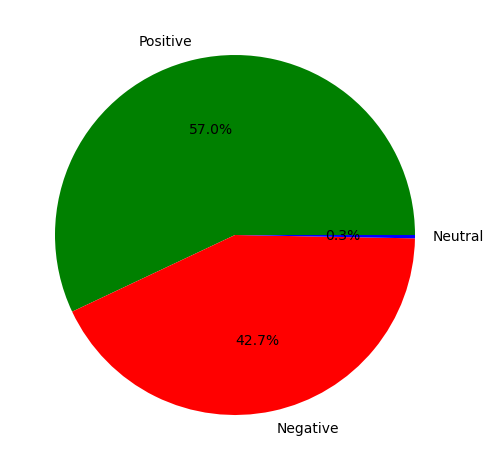

In [67]:
sentiment_count = df2['sentiment_category'].value_counts()

# Create a pie chart based on sentiment counts
sentiment_count.plot(kind='pie', autopct='%1.1f%%', colors=['green', 'red', 'blue'])
plt.ylabel('')
plt.tight_layout()
print(sentiment_count)

### Text Blob

In [68]:
from textblob import TextBlob

# Create a textblob
text = "Your review or text here"
blob = TextBlob(text)

# Analyze sentiment
sentiment = blob.sentiment 
print(f" Polarity: {sentiment.polarity}, Subjectivity: {sentiment.subjectivity}")

# Analyze sentiment fr individual sentences
for sentence in blob.sentences:
    print(f"Sentence: {sentence}")
    print(f"Sentiment: {sentence.sentiment}")

 Polarity: 0.0, Subjectivity: 0.0
Sentence: Your review or text here
Sentiment: Sentiment(polarity=0.0, subjectivity=0.0)


In [70]:
# Load your data
df3 = pd.read_csv('cleaned_skytrax_reviews.csv')

# Apply TextBlob sentiment analysis
df3['polarity'] = df3['Review'].apply(lambda x: TextBlob(x).sentiment.polarity)
df3['subjectivity'] = df3['Review'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# Display results
print(df3[['Review', 'polarity', 'subjectivity']].head())

                                              Review  polarity  subjectivity
0  Flight mainly let down by a disagreeable fligh...  0.207461      0.539853
1  Another awful experience by British Airways. T... -0.320000      0.413333
2  The service was rude, full of attitude to me, ... -0.045833      0.520833
3  This flight was a joke. There was four people ... -0.450000      0.650000
4  This time British Airways managed to get every...  0.370966      0.626984


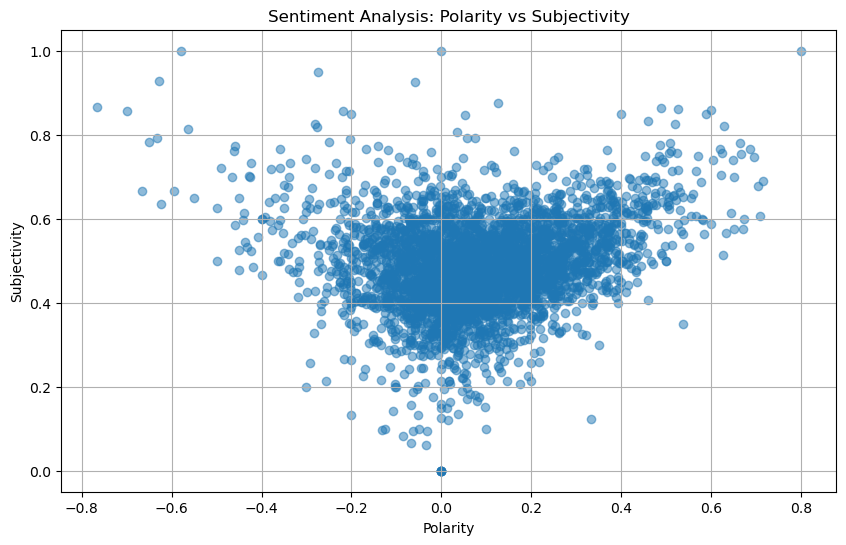

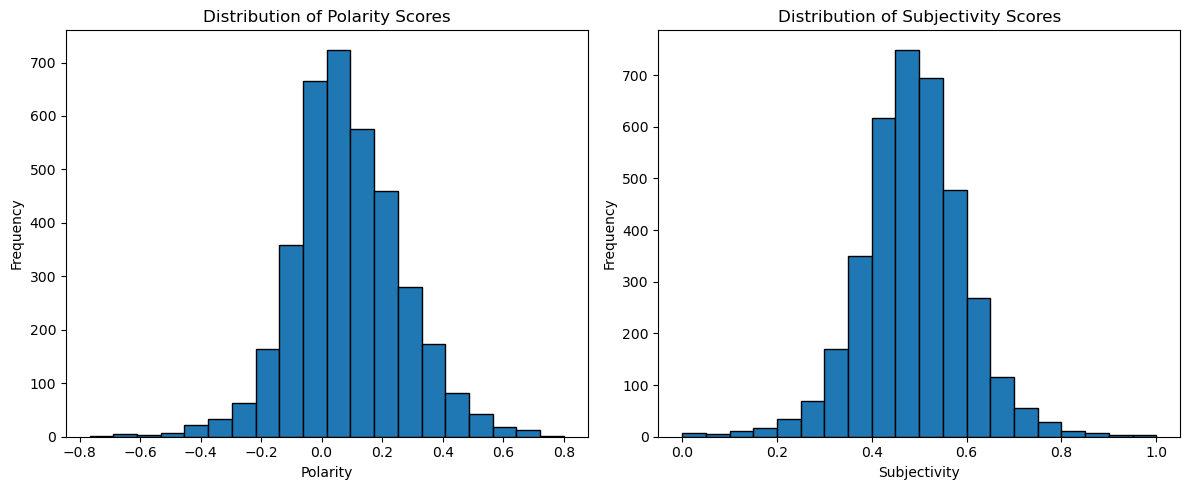

In [71]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df3['polarity'], df3['subjectivity'], alpha=0.5)
plt.title('Sentiment Analysis: Polarity vs Subjectivity')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.grid(True)
plt.show()

# Create histograms
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.hist(df3['polarity'], bins=20, edgecolor='black')
ax1.set_title('Distribution of Polarity Scores')
ax1.set_xlabel('Polarity')
ax1.set_ylabel('Frequency')

ax2.hist(df3['subjectivity'], bins=20, edgecolor='black')
ax2.set_title('Distribution of Subjectivity Scores')
ax2.set_xlabel('Subjectivity')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

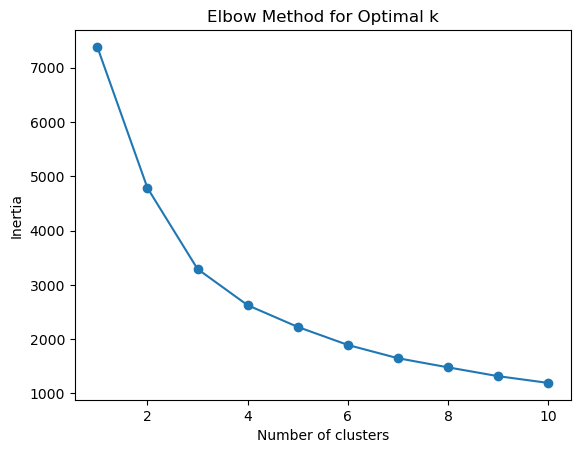

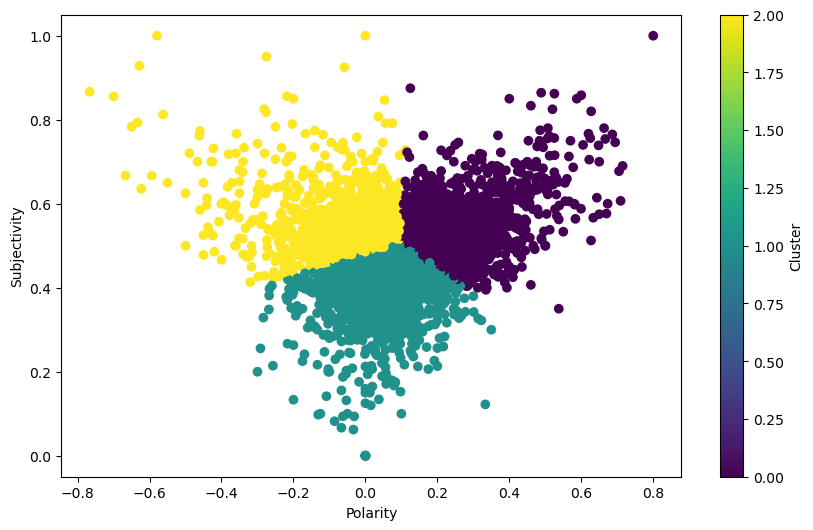

Cluster Averages:
         polarity  subjectivity
cluster                        
0        0.275016      0.549659
1        0.040944      0.392076
2       -0.073661      0.558705

Cluster 0 Reviews:

Cluster 0 Reviews:
-Flight mainly let down by a disagreeable flight attendant. No queue to check in at Cape Town - good. However checkin agent was unfamiliar with BA size and weight rules for sports bags so had to wait 10 minutes while phone calls were made -- annoying. Lounge was good. Gate service was excellent with organised queues. Seat was good (the new upgraded Club Suite). The zip broke off the amenity kit so it was unusable -- BA cutting corners too much here. Offered a cocktail service which came promptly and the drink was excellent. But no nuts! So I went off to the galley to ask for some nuts or a snack to go with it. I spoke to a male flight attendant who looked at me with utter distaste that I had the temerity to ask for nuts. The he said "where have you come from?". What a biz

In [72]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Prepare data for clustering
X = df3[['polarity', 'subjectivity']]

# Scale the data for K-means
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine the optimal number of clusters using Elbow method
inertia = []
for i in range(1,11): 
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1,11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

# Apply K-Means clustering
n_clusters = 3 # Set the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
df3['cluster'] = kmeans.fit_predict(X_scaled) # Create new column title cluster

# Define colors for each cluster
cluster_colors = {
    0: 'yellow',
    1: 'purple',
    2: 'green',
}

# Create colored cluster names
colored_cluster_names = [
    f"\033[93mCluster 0 (Yellow)\033[0m" if i == 0 else (
        f"\033[95mCluster 1 (Purple)\033[0m" if i == 1 else
        f"\033[92mCluster 2 (Green)\033[0m"
    ) for i in range(n_clusters)]

# Visulalize the clustere
plt.figure(figsize=(10,6))
plt.scatter(df3['polarity'], df3['subjectivity'], c=df3['cluster'])
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.colorbar(label='Cluster') # To clearly identify which color responds to which cluster
plt.show()

# Analyze the clusters
cluster_summary = df3.groupby('cluster')[['polarity', 'subjectivity']].mean()
print("Cluster Averages:")
print(cluster_summary)

# Examine the reviews within each clluster
for i in range(n_clusters):
    color_code = cluster_colors[i]
    print(f"\nCluster {i} Reviews:")
    print(f"\n\033[91mCluster {i} Reviews:\033[0m") 
    cluster_reviews = df3[df3['cluster'] == i]['Review'].head(5) # Print the first 5 reviews
    
    for review in cluster_reviews:
        print(f"-{review}")

In [73]:
df3.head()

,Review,polarity,subjectivity,cluster
0,Flight mainly let down by a disagreeable fligh...,0.207461,0.539853,0
1,Another awful experience by British Airways. T...,-0.320000,0.413333,2
2,"The service was rude, full of attitude to me, ...",-0.045833,0.520833,2
3,This flight was a joke. There was four people ...,-0.450000,0.650000,2
4,This time British Airways managed to get every...,0.370966,0.626984,0


# Word Cloud

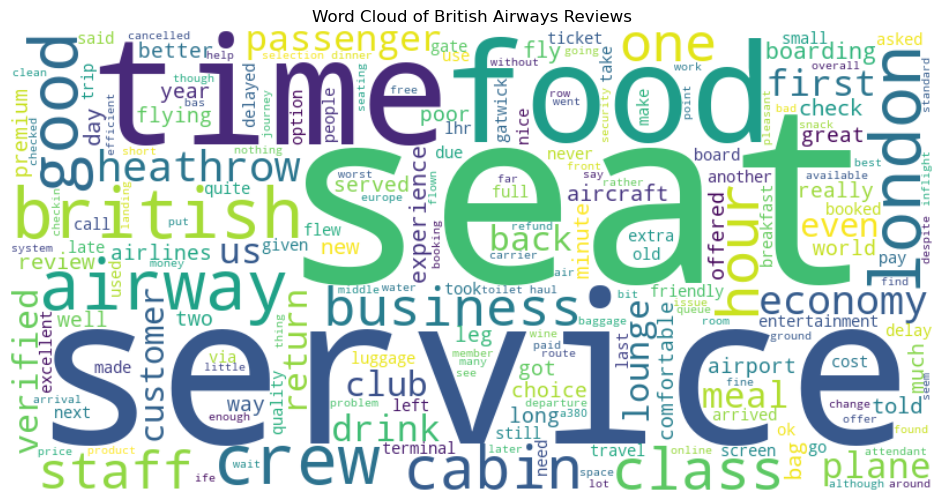

In [74]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import contractions
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Load your data
df4 = pd.read_csv('cleaned_skytrax_reviews.csv')


# 1. Define Preprocessing Functions (as in your notebook)
def expand_contractions(text):
    return contractions.fix(text)


def remove_punctuation(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text


# 2. Create Stopword List (and lowercase it!)
stop_words = set(stopwords.words('english'))
# add extra stopwords to remove noise from wordcloud
extra_stopwords = ['flight', 'flights', 'airline', 'British', 'Airways', 'ba']
stop_words = stop_words.union(extra_stopwords)


def remove_stopwords(text):
    words = [word.lower() for word in word_tokenize(text) if word.lower() not in stop_words]
    return ' '.join(words)


# Apply preprocessing
df4['processed_review'] = df4['Review'].apply(expand_contractions)
df4['processed_review'] = df4['processed_review'].apply(remove_punctuation)
df4['processed_review'] = df4['processed_review'].apply(remove_stopwords)

# Combine all processed reviews into a single string
all_text = ' '.join(df4['processed_review'])

# 3. Create Word Cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=200,  # Adjust as needed
    colormap='viridis',  # Optional: Choose a colormap
    collocations=False # Prevent duplicate words
).generate(all_text)

# 4. Plot Word Cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of British Airways Reviews')
plt.show()
